In [1]:
import os
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def random_rotation(img): # called in images_random_affine
    # Choose a random angle from -10 to -5 or 5 to 10 degrees
    if random.random() > 0.5:
        angle = random.uniform(-10, -5)
    else:
        angle = random.uniform(5, 10)
    return TF.rotate(img, angle)

# Définir la transformation des données, à la fois pour convenir au ResNet ("Resize(224)")
# et pour augmenter le dataset tout en l'équilibrant
data_transforms = {
    'original_images': transforms.Compose([
        # Suppression du bandeau vertical sur les images originelles
        transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Data augmentation techniques,
    'images_horizontally_flipped': transforms.Compose([
        transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
        transforms.RandomHorizontalFlip(1),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'images_random_affine': transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.crop(img, top=0, left=0, height=img.height - 32, width=img.width)),
    transforms.Lambda(random_rotation),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'images_random_perspective': transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Utiliser un GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Chemin vers le dataset
data_dir = 'training_data'

In [3]:
classes = ['badger', 'bird', 'cat', 'fox', 'mouse', 'rabbit']

# Create the original dataset
def create_original_dataset(transform):
    transformed_images = []
    for class_name in classes:
        print(class_name)
        for img in os.listdir(os.path.join(data_dir, class_name)):
            img_path = os.path.join(data_dir, class_name, img)
            image = Image.open(img_path)
            resized_img = transform(image)
            transformed_images.append((resized_img, class_name))
    return transformed_images

# Create datasets for each type of transformation
original_dataset = create_original_dataset(data_transforms['original_images'])

badger


In [12]:
# Dictionnaire basé sur la répartition originelle des classes
class_augmentation_probabilities = {
    'badger': 0.24,  
    'bird': 0.24,
    'cat': 0.52,
    'fox': 0,
    'mouse': 1,
    'rabbit': 0.53
}

images_to_horizontally_flip = {}
images_to_random_affine = {}
images_to_random_perspective = {}

for class_name, probability in class_augmentation_probabilities.items():
    # Filter the images for each class based on the probability
    class_images = [img for img in os.listdir(os.path.join(data_dir, class_name)) if random.random() < probability]
    images_to_horizontally_flip[class_name] = class_images

for class_name, probability in class_augmentation_probabilities.items():
    # Filter the images for each class based on the probability
    class_images = [img for img in os.listdir(os.path.join(data_dir, class_name)) if random.random() < probability]
    images_to_random_affine[class_name] = class_images
    
for class_name, probability in class_augmentation_probabilities.items():
    # Filter the images for each class based on the probability
    class_images = [img for img in os.listdir(os.path.join(data_dir, class_name)) if random.random() < probability]
    images_to_random_perspective[class_name] = class_images

# Now, create datasets for each transformation with filtered images
def create_transformed_dataset(transform, images_list):
    transformed_images = []
    for class_name, images in images_list.items():
        print(class_name)
        for img in images:
            img_path = os.path.join(data_dir, class_name, img)
            image = Image.open(img_path)  # Load the image
            transformed_img = transform(image)
            transformed_images.append((transformed_img, class_name))
    return transformed_images

# Create datasets for each type of transformation
horizontal_flip_dataset = create_transformed_dataset(data_transforms['images_horizontally_flipped'], images_to_horizontally_flip)
print("horizontal OK")
affine_transform_dataset = create_transformed_dataset(data_transforms['images_random_affine'], images_to_random_affine)
print("affine OK")
perspective_transform_dataset = create_transformed_dataset(data_transforms['images_random_perspective'], images_to_random_perspective)

badger
bird
cat
fox
mouse
rabbit
horizontal OK
badger
bird
cat
fox
mouse
rabbit
affine OK
badger
bird
cat
fox
mouse
rabbit


In [85]:
# Function to convert a tensor to a PIL image
def tensor_to_pil(tensor):
    # Inverse normalization of the image
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    # Inverse normalization of the tensor
    inv_tensor = inv_normalize(tensor)
    # Clamp the image data to valid range (0-1)
    inv_tensor = inv_tensor.clamp(0, 1)
    # Convert to PIL Image
    pil_image = transforms.ToPILImage()(inv_tensor)
    return pil_image

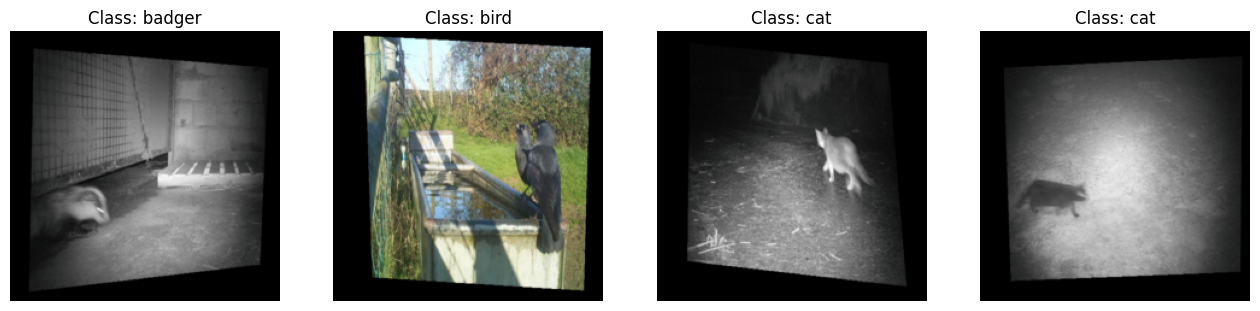

In [70]:
num_images = 4

# Create a figure with subplots
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 4))

# Loop through the first few images
for i in range(num_images):
    image_tensor, class_name = perspective_transform_dataset[(i+1)*600]  # Change dataset name if necessary
    image_pil = tensor_to_pil(image_tensor)
    # Plot each image
    ax = axes[i]
    ax.imshow(image_pil)
    ax.set_title(f"Class: {class_name}")
    ax.axis('off')  # Turn off axis

plt.show()

In [16]:
combined_dataset = original_dataset + horizontal_flip_dataset + affine_transform_dataset + perspective_transform_dataset

In [22]:
print("len(original_dataset): ", len(original_dataset))
print("len(horizontal): ", len(horizontal_flip_dataset))
print('len(affine): ', len(affine_transform_dataset))
print('len(perspective): ', len(perspective_transform_dataset))

len(original_dataset):  8368
len(horizontal):  2413
len(affine):  2378
len(perspective):  2355


In [18]:
class_occurences = {
    'badger' : 0,
    'bird': 0,
    'cat': 0,
    'fox': 0,
    'mouse': 0,
    'rabbit': 0
}

for img in combined_dataset:
    class_occurences[str(img[1])] += 1

In [19]:
class_occurences

{'badger': 2683,
 'bird': 2658,
 'cat': 2781,
 'fox': 2693,
 'mouse': 2280,
 'rabbit': 2419}